### Data load

In [1]:
import pandas as pd
file_path = './data/195_Exathlon_id_22_Facility_tr_10766_1st_12590.csv'
df = pd.read_csv(file_path)

df

,1_executor_threadpool_activeTasks_value,1_jvm_heap_max_value,1_jvm_pools_PS-Eden-Space_committed_value,1_jvm_pools_PS-Eden-Space_max_value,1_jvm_pools_PS-Eden-Space_usage_value,1_jvm_pools_PS-Survivor-Space_usage_value,2_executor_threadpool_activeTasks_value,2_jvm_heap_committed_value,2_jvm_heap_max_value,2_jvm_heap_usage_value,...,node8_CPU015_Idle%,node8_CPU015_Sys%,node8_CPU015_User%,node8_CPU_ALL_Sys%,node8_CPU_ALL_User%,node8_NETPACKET_ib0-write/s,node8_NET_ib0-read-KB/s,node8_PROC_pswitch,node8_VM_pgalloc_normal,Label
0,-1.0,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000,-1.0,-1.000000e+00,-1.000000e+00,-1.000000,...,96.0,0.0,4.0,0.5,4.8,25.9,2.9,23741.2,50353.0,0
1,-1.0,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000,-1.0,-1.000000e+00,-1.000000e+00,-1.000000,...,94.0,0.0,6.0,0.6,5.3,14.0,1.9,13408.6,115029.0,0
2,0.0,7.635730e+09,5.373952e+08,2.684879e+09,0.069621,0.000000,-1.0,-1.000000e+00,-1.000000e+00,-1.000000,...,100.0,0.0,0.0,0.1,0.3,7.0,0.5,2828.8,785.0,0
3,0.0,7.635730e+09,5.373952e+08,2.684879e+09,0.070958,0.000000,0.0,1.533018e+09,7.635730e+09,0.028567,...,100.0,0.0,0.0,0.0,0.1,6.0,0.7,1310.7,118.0,0
4,3.0,7.635730e+09,5.373952e+08,2.684879e+09,0.083218,0.000000,3.0,1.533018e+09,7.635730e+09,0.033346,...,100.0,0.0,0.0,0.5,1.4,4.0,0.4,27200.7,29489.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43061,3.0,8.204583e+09,2.074608e+09,2.074608e+09,0.360998,0.415096,3.0,8.294760e+09,8.294760e+09,0.705279,...,80.2,0.0,19.8,0.3,9.7,974.5,39273.7,16749.2,25532.0,1
43062,3.0,7.937196e+09,2.074608e+09,2.352480e+09,0.848696,0.998915,3.0,8.319402e+09,8.319402e+09,0.822731,...,73.5,1.0,25.5,0.3,13.2,1464.5,32557.6,15519.7,33887.0,1
43063,1.0,8.189379e+09,2.087715e+09,2.126512e+09,0.911851,0.387403,2.0,8.121221e+09,8.121221e+09,0.450716,...,72.3,2.1,25.5,0.3,5.9,1858.2,65116.2,17215.0,37882.0,1
43064,1.0,8.176271e+09,2.087715e+09,2.117599e+09,0.197564,0.793149,1.0,8.121221e+09,8.121221e+09,0.484818,...,70.1,3.1,26.8,0.3,1.6,1427.0,39003.0,16681.8,28801.0,1


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import os
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from mscred.utils import *
from mscred.mscred import MSCRED


train_end_idx = 10766
val_start_idx = int(train_end_idx * 0.9)


label_column = df.columns[-1]
labels = df[label_column]
data = df.drop(columns=[label_column])


train_data = data.iloc[:val_start_idx]
val_data = data.iloc[val_start_idx:train_end_idx]
test_data = data.iloc[train_end_idx:]
test_labels = labels.iloc[train_end_idx:]

scaler = StandardScaler()
train_slice = scaler.fit_transform(train_data.values)
scaler_path = "scaler.pkl"
joblib.dump(scaler, scaler_path)  # scaler 저장

X, y = calculate_signature_matrix_dataset(train_slice, lags=[10, 30, 60], stride=1, num_timesteps=5)
X = X.transpose(0, 4, 1, 2, 3)
y = y.transpose(0, 3, 1, 2)
X_train = torch.Tensor(X)
y_train = torch.Tensor(y)

val_slice = scaler.transform(val_data.values)
X, y = calculate_signature_matrix_dataset(val_slice, lags=[10, 30, 60], stride=1, num_timesteps=5)
X = X.transpose(0, 4, 1, 2, 3)
y = y.transpose(0, 3, 1, 2)
X_val = torch.Tensor(X)
y_val = torch.Tensor(y)


test_slice = scaler.transform(test_data.values)
X, y = calculate_signature_matrix_dataset(test_slice, lags=[10, 30, 60], stride=1, num_timesteps=5)
X = X.transpose(0, 4, 1, 2, 3)
y = y.transpose(0, 3, 1, 2)
X_test = torch.Tensor(X)
y_test = torch.Tensor(y)
test_labels = torch.Tensor(test_labels.values)


train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=64, shuffle=False)



100%|██████████| 32241/32241 [00:54<00:00, 592.71it/s]


In [3]:

print("Train Loader Shapes:")
for X_batch, y_batch in train_loader:
    print(f"X: {X_batch.shape}, y: {y_batch.shape}")
    break

print("\nValidation Loader Shapes:")
for X_batch, y_batch in val_loader:
    print(f"X: {X_batch.shape}, y: {y_batch.shape}")
    break

print("\nTest Loader Shapes:")
for X_batch, y_batch in test_loader:
    print(f"X: {X_batch.shape}, y: {y_batch.shape}")
    break

print("\nTest Labels Shape:")
print(test_labels.shape)

Train Loader Shapes:
X: torch.Size([64, 3, 5, 31, 31]), y: torch.Size([64, 3, 31, 31])

Validation Loader Shapes:
X: torch.Size([64, 3, 5, 31, 31]), y: torch.Size([64, 3, 31, 31])

Test Loader Shapes:
X: torch.Size([64, 3, 5, 31, 31]), y: torch.Size([64, 3, 31, 31])

Test Labels Shape:
torch.Size([32300])


### Train

100%|██████████| 151/151 [00:08<00:00, 18.57it/s]


Epoch 1, Train Loss: 0.48894011545062854, Validation Loss: 0.5388513668440282


100%|██████████| 151/151 [00:07<00:00, 18.90it/s]


Epoch 2, Train Loss: 0.17310954632841988, Validation Loss: 0.431970689445734


100%|██████████| 151/151 [00:07<00:00, 18.92it/s]


Epoch 3, Train Loss: 0.11823679959487836, Validation Loss: 0.35321284737437963


100%|██████████| 151/151 [00:08<00:00, 18.71it/s]


Epoch 4, Train Loss: 0.09923975381827513, Validation Loss: 0.3432843266054988


100%|██████████| 151/151 [00:07<00:00, 18.97it/s]


Epoch 5, Train Loss: 0.08791451884544646, Validation Loss: 0.3167004492133856


100%|██████████| 151/151 [00:08<00:00, 18.21it/s]


Epoch 6, Train Loss: 0.0747163775716199, Validation Loss: 0.302486922359094


100%|██████████| 151/151 [00:07<00:00, 18.94it/s]


Epoch 7, Train Loss: 0.08281613676037812, Validation Loss: 0.29614625545218587


100%|██████████| 151/151 [00:08<00:00, 18.67it/s]


Epoch 8, Train Loss: 0.06271596272963266, Validation Loss: 0.25112713570706546


100%|██████████| 151/151 [00:07<00:00, 18.94it/s]


Epoch 9, Train Loss: 0.05851170020979761, Validation Loss: 0.2622740585356951


100%|██████████| 151/151 [00:07<00:00, 18.93it/s]


Epoch 10, Train Loss: 0.1317367937896919, Validation Loss: 0.3494229447096586


100%|██████████| 151/151 [00:07<00:00, 19.00it/s]


Epoch 11, Train Loss: 0.07966741915200128, Validation Loss: 0.27563630254007876


100%|██████████| 151/151 [00:08<00:00, 18.79it/s]


Epoch 12, Train Loss: 0.06437621207056654, Validation Loss: 0.25669436948373914


100%|██████████| 151/151 [00:08<00:00, 18.58it/s]


Epoch 13, Train Loss: 0.05703055951435933, Validation Loss: 0.24350607907399535


100%|██████████| 151/151 [00:07<00:00, 18.89it/s]


Epoch 14, Train Loss: 0.05444248644820112, Validation Loss: 0.24107891274616122


100%|██████████| 151/151 [00:07<00:00, 18.89it/s]


Epoch 15, Train Loss: 0.071328464358897, Validation Loss: 0.2896567687857896


100%|██████████| 151/151 [00:08<00:00, 18.77it/s]


Epoch 16, Train Loss: 0.06042941808022115, Validation Loss: 0.2290394597221166


100%|██████████| 151/151 [00:08<00:00, 18.87it/s]


Epoch 17, Train Loss: 0.05369982556039036, Validation Loss: 0.22359079425223172


100%|██████████| 151/151 [00:07<00:00, 18.95it/s]


Epoch 18, Train Loss: 0.05192465542056999, Validation Loss: 0.22509598918259144


100%|██████████| 151/151 [00:07<00:00, 18.99it/s]


Epoch 19, Train Loss: 0.04971070246252891, Validation Loss: 0.21588114299811423


100%|██████████| 151/151 [00:08<00:00, 18.21it/s]


Epoch 20, Train Loss: 0.07767183917408056, Validation Loss: 0.24428204423747957


100%|██████████| 151/151 [00:08<00:00, 18.58it/s]


Epoch 21, Train Loss: 0.053658972589903514, Validation Loss: 0.22689224011264741


100%|██████████| 151/151 [00:07<00:00, 18.96it/s]


Epoch 22, Train Loss: 0.06426344053289354, Validation Loss: 0.2323953330051154


100%|██████████| 151/151 [00:07<00:00, 18.94it/s]


Epoch 23, Train Loss: 0.05984875007489363, Validation Loss: 0.27035156241618097


100%|██████████| 151/151 [00:08<00:00, 18.68it/s]


Epoch 24, Train Loss: 0.05352725842289183, Validation Loss: 0.225657032802701


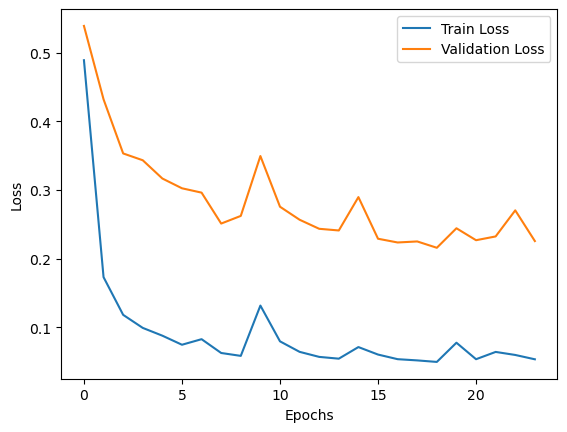

In [4]:
model_path = './weights/weights_mscred.pt'
model = MSCRED(num_timesteps=5, attention=True).cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)
criterion = nn.MSELoss()
best_loss = float('inf')
train_losses, val_losses = [], []
j = 0  # Early stopping counter

early_stop_rounds = 5
for epoch in range(50):
    if j >= early_stop_rounds:
        break

    train_loss = 0.0
    val_loss = 0.0

   
    model.train()
    for batch_x, batch_y in tqdm(train_loader):
        batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()


    model.eval()
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
            output = model(batch_x)
            loss = criterion(output, batch_y)
            val_loss += loss.item()

   
    if val_loss < best_loss:
        best_loss = val_loss
        j = 0
        torch.save(model.state_dict(), model_path)
    else:
        j += 1

   
    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")
    scheduler.step()


plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Test

In [6]:
loaded_model = MSCRED().cuda()
loaded_model.load_state_dict(torch.load(model_path))
loaded_scaler = joblib.load(scaler_path)
print('model & scaler loaded')

model & scaler loaded


/tmp/ipykernel_1087474/1770413205.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(model_path))


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, f1_score
import torch

class AnomalyScoreVisualizer:
    def __init__(self, model, threshold=10):
        self.model = model
        self.threshold = threshold

    def test_model(self, test_loader):
        print('Predicting...')
        outputs = []
        true_values = []
        with torch.no_grad():
            for batch_x in test_loader:
                true_values.append(batch_x[1].numpy())
                output = self.model(batch_x[0].cuda()).cpu().numpy()
                outputs.append(output)
        outputs = np.concatenate(outputs, axis=0)
        true_values = np.concatenate(true_values, axis=0)
        return true_values, outputs

    def calculate_anomaly_score(self, true, pred):
        residual_matrix = np.abs(true - pred)
        anomaly_score = np.sum(residual_matrix > self.threshold, axis=(1, 2, 3))
        return anomaly_score, residual_matrix

    def find_best_threshold(self, true_labels, anomaly_scores):
        thresholds = np.linspace(min(anomaly_scores), max(anomaly_scores), 1000)
        best_f1 = 0
        best_threshold = self.threshold

        for thresh in thresholds:
            predicted_labels = (anomaly_scores > thresh).astype(int)
            f1 = f1_score(true_labels, predicted_labels)
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = thresh

        print(f"Best Threshold: {best_threshold:.4f}, Best F1-Score: {best_f1:.4f}")
        return best_threshold, best_f1

    def evaluate(self, true_labels, anomaly_scores):
 
        if len(anomaly_scores) < len(true_labels):
            padding = np.zeros(len(true_labels) - len(anomaly_scores))
            anomaly_scores = np.concatenate([padding, anomaly_scores])

     
        self.threshold, best_f1 = self.find_best_threshold(true_labels, anomaly_scores)

        predicted_labels = (anomaly_scores > self.threshold).astype(int)
        auroc = roc_auc_score(true_labels, anomaly_scores)
        auprc = average_precision_score(true_labels, anomaly_scores)
        accuracy = accuracy_score(true_labels, predicted_labels)
        f1 = f1_score(true_labels, predicted_labels)

        print(f"AUROC: {auroc:.4f}, AUPRC: {auprc:.4f}, Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}")
        return auroc, auprc, accuracy, f1

    def visualize(self, test_loader, true_labels):
        true_values, predictions = self.test_model(test_loader)
        anomaly_score, _ = self.calculate_anomaly_score(true_values, predictions)

       
        if len(anomaly_score) < len(true_labels):
            padding = np.zeros(len(true_labels) - len(anomaly_score))
            anomaly_score = np.concatenate([padding, anomaly_score])

        plt.figure(figsize=(10, 6))
        plt.plot(anomaly_score, label='Anomaly Score', color='black')

    
        anomaly_indices = np.where(true_labels == 1.0)[0]
        plt.fill_between(
            range(len(true_labels)), 0, max(anomaly_score, default=1),
            where=(true_labels == 1.0), color='red', alpha=0.3, label='True Anomalies'
        )

        plt.title('Anomaly Score Over Time with True Anomalies')
        plt.xlabel('Time Step')
        plt.ylabel('Anomaly Score')
        plt.legend()
        plt.grid()
        plt.show()

        return anomaly_score


Predicting...


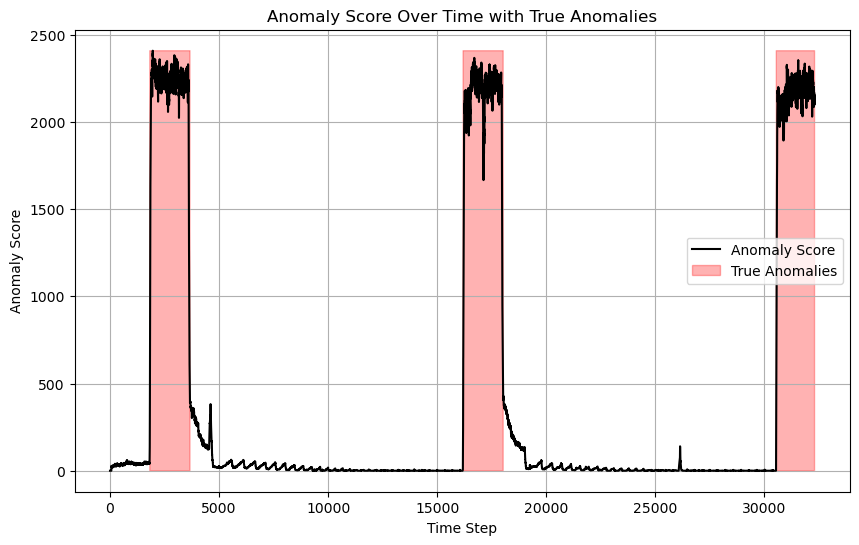

Best Threshold: 424.4084, Best F1-Score: 0.9984
AUROC: 1.0000, AUPRC: 0.9999, Accuracy: 0.9995, F1-Score: 0.9984


(0.9999754337657181,
 0.9998882160809142,
 0.9994736842105263,
 0.9984344783129202)

In [10]:

visualizer = AnomalyScoreVisualizer(loaded_model)
anomaly_scores = visualizer.visualize(test_loader, test_labels.numpy())
visualizer.evaluate(test_labels.numpy(), anomaly_scores)